BEGIN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from datetime import datetime

~"numpy" is a package used for scientific computing. It is used in this program to perform linear algebraic operations on our data.


~"as" just makes it so that you may refer to the imported package with a different call.


~"pandas" is a package used for data manipulation and analysis. In this program it is used to:-
- read our data into the program (pd.read("File directory"))
- concatenating variable columns for use in the machine learning section (pd.concat([dataset1,dataset2])
-simplifying categorical variables by producing dummy variables that represent them numerically. (pd.get_dummies(data))

~"seaborn" is a package that is used in this program to visualise "SalePrice"'s skewedness and how the logarithmic operation from numpy makes "SalePrice" a better fit to a normalised distribution of data.


In [2]:
from scipy.stats import skew
from scipy.stats import norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [4]:

from xgboost import XGBRegressor


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('START data processing', datetime.now(), )

START data processing 2019-03-05 23:05:49.838120


In [6]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

Remove ID from the excel files as it will not be used in predictions.

In [7]:
train = train[train.GrLivArea < 5000]
train.reset_index(drop=True, inplace=True)

Manual deletion of an outlier. This has been determined to be an outlier by using this calculator: https://www.graphpad.com/quickcalcs/Grubbs1.cfm

C:\Users\G\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


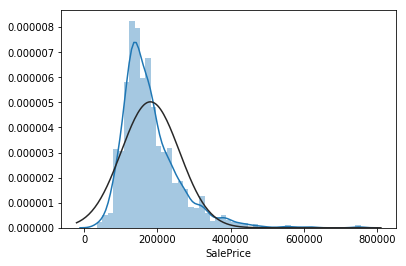

In [8]:
sb.distplot(train['SalePrice'], fit = norm);

Graph shows positive skewedness. According to the "Comprehensive data exploration with Python" kernel in Kaggle, applying a natural log operation will work well with this.

In [9]:
train["SalePrice"] = np.log1p(train["SalePrice"])

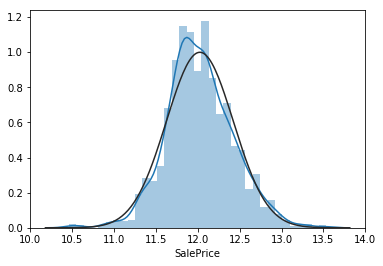

In [10]:
sb.distplot(train['SalePrice'], fit = norm);

In [11]:
y = train.SalePrice.reset_index(drop=True) # To be used later to calculate the mean squared error of our predictions.
train_variables = train.drop(['SalePrice'], axis=1)
test_variables = test

In [12]:
variables = pd.concat([train_variables, test_variables]).reset_index(drop=True) # 


variables['MSSubClass'] = variables['MSSubClass'].apply(str)
variables['YrSold'] = variables['YrSold'].astype(str)
variables['MoSold'] = variables['MoSold'].astype(str)
##################BEGIN FILLING NULL VARIABLES###########################################
variables['Functional'] = variables['Functional'].fillna('Typ')
variables['Electrical'] = variables['Electrical'].fillna("SBrkr")
variables['KitchenQual'] = variables['KitchenQual'].fillna("TA")
variables['Exterior1st'] = variables['Exterior1st'].fillna(variables['Exterior1st'].mode()[0])
variables['Exterior2nd'] = variables['Exterior2nd'].fillna(variables['Exterior2nd'].mode()[0])
variables['SaleType'] = variables['SaleType'].fillna(variables['SaleType'].mode()[0])

variables["PoolQC"] = variables["PoolQC"].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    variables[col] = variables[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    variables[col] = variables[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    variables[col] = variables[col].fillna('None')
variables['MSZoning'] = variables.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in variables.columns:
    if variables[i].dtype == object:
        objects.append(i)
variables.update(variables[objects].fillna('None'))

variables['LotFrontage'] = variables.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [13]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in variables.columns:
    if variables[i].dtype in numeric_dtypes:
        numerics.append(i)
variables.update(variables[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in variables.columns:
    if variables[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_variables = variables[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_variables[skew_variables > 0.5]
skew_index = high_skew.index

for i in skew_index:
    variables[i] = boxcox1p(variables[i], boxcox_normmax(variables[i] + 1))


In [14]:
variables = variables.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

variables['YrBltAndRemod']=variables['YearBuilt']+variables['YearRemodAdd']
variables['TotalSF']=variables['TotalBsmtSF'] + variables['1stFlrSF'] + variables['2ndFlrSF']

variables['Total_sqr_footage'] = (variables['BsmtFinSF1'] + variables['BsmtFinSF2'] +
                                 variables['1stFlrSF'] + variables['2ndFlrSF'])

variables['Total_Bathrooms'] = (variables['FullBath'] + (0.5 * variables['HalfBath']) +
                               variables['BsmtFullBath'] + (0.5 * variables['BsmtHalfBath']))

variables['Total_porch_sf'] = (variables['OpenPorchSF'] + variables['3SsnPorch'] +
                              variables['EnclosedPorch'] + variables['ScreenPorch'] +
                              variables['WoodDeckSF'])

In [15]:
variables['haspool'] = variables['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
variables['has2ndfloor'] = variables['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
variables['hasgarage'] = variables['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
variables['hasbsmt'] = variables['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
variables['hasfireplace'] = variables['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


In [16]:
final_variables = pd.get_dummies(variables).reset_index(drop=True)

In [17]:
X = final_variables.iloc[:len(y), :]
X_sub = final_variables.iloc[len(X):, :]

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

In [18]:
# ################## ML ########################################
print('START ML', datetime.now(), )

START ML 2019-03-05 23:05:50.644827


In [19]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [20]:
print('START Fit')

print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)


START Fit
2019-03-05 23:05:50.670619 xgboost


In [21]:
print('Predict submission', datetime.now(),)
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(xgb_model_full_data.predict(X_sub)))
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("ProvisionalSubmission.csv", index=False)
print('Save submission', datetime.now(),)

Predict submission 2019-03-05 23:05:57.420675
Save submission 2019-03-05 23:05:57.542195
